try to delete v_list


In [2]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [ ]:
def evaluate_Q_at(model, y_val, solver):
    """
    在给定 y=y_val 下，最小化 obj_expr，返回 v(y)。
    该函数会临时增加 Objective，并在结束后清理，不改变模型结构。
    """
    # 清掉可能残留的 As/pw/obj（防止上一轮留下）
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # 固定 y，建临时目标并求解
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # 允许你在这里选择 raise 或返回 NaN/报warning
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)

    # 清理
    model.del_component('obj')
    model.y.unfix()

    return v_y


def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    改成：不再用 v_list 的解析表达式生成节点函数值，
    而是通过“固定 y 解模型”来得到各 scenario 在节点上的真值。
    其它流程尽量维持不变。
    """
    N = len(model_list)
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()

    y_opt_list = [None]*N
    as_nodes_list = [None]*N
    ms_list = [None]*N
    new_nodes_list = [None]*N
    eff_node_count = 0
    min_index = None
    new_node = None

    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2

    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)

    print('start')
    for k in range(add_node_num+1):
        print('Adding node ', k)
        for i in range(N):
            print('Solving scenario ', i)

            # === NEW: 用“固定 y 解模型”得到节点真值 v(y) ===
            vals = []
            for yv in y_nodes:
                vy = evaluate_Q_at(model_list[i], yv, solver)  # v_i(yv)
                vals.append(vy)
            as_nodes_list[i] = vals  # 这些值将作为 Piecewise 的 f_rule

            # === 下面与原逻辑一致：重建 Piecewise 与 underestimator ===
            for comp in ['As', 'pw', 'obj']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)

            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # 目标：min (Q - A)
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i], tee=False)

            status_ok = (results.solver.status == SolverStatus.ok)
            term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
            if not (status_ok and term_ok):
                print(f"⚠ Scenario {i} not optimal: "
                      f"status={results.solver.status}, term={results.solver.termination_condition}")

            # 建议直接读 model 的目标值（比 results.problem.lower_bound 更稳妥）
            ms_val = value(model_list[i].obj)
            ms_list[i] = ms_val

            # 检查新节点是否过近
            y_new = value(model_list[i].y)
            if (k > 0) and (abs(new_nodes_list[i] - y_new) <= 1e-6):
                print("The new node is too close and not inserted")
                continue  # 这里用 continue 更合理

            new_nodes_list[i] = y_new

        # 选择一个场景的“最差”节点加入全局节点集
        if k < add_node_num:
            min_index = int(np.argmin(ms_list))
            new_node = new_nodes_list[min_index]
            if (new_node not in y_nodes):
                bisect.insort(y_nodes, new_node)
                eff_node_count += 1

    # === 汇总模型 ===
    assum_nodes = np.sum(as_nodes_list, axis=0)  # 所有场景的 v(y) 逐点求和
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr=model_sum.As, sense=minimize)
    res_sum = solver.solve(model_sum, tee=False)

    status_ok = (res_sum.solver.status == SolverStatus.ok)
    term_ok = (res_sum.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        print("Sum model doesn't get solved normally",
              res_sum.solver.status, res_sum.solver.termination_condition)

    # 误差（你原来有个 mmm 未定义，这里按常见做法给出一个可运行的版本）：
    # 常见地：errors = min_y sum(Q_i(y)) - sum_i min_y (Q_i(y) - A_i(y))
    # 这里 sum 模型的目标值就是 min_y sum(Q_i(y)) = value(model_sum.As)
    sum_min = value(model_sum.As)
    gap_sum = sum(ms_list)  # 每个场景的 min_y (Q - A)
    errors = sum_min - gap_sum

    # 直径
    delta = (new_ub - new_lb) / 2

    return (delta, errors, y_nodes,
            as_nodes_list[0], ms_list[0],
            (as_nodes_list[1] if N > 1 else None),
            (ms_list[1] if N > 1 else None),
            eff_node_count, min_index, new_node)


In [19]:
def evaluate_Q_at(model, y_val, solver):
    """
    在给定 y=y_val 下，最小化 obj_expr，返回 v(y)。
    该函数会临时增加 Objective，并在结束后清理，不改变模型结构。
    """
    # 清掉可能残留的 As/pw/obj（防止上一轮留下）
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # 固定 y，建临时目标并求解
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # 允许你在这里选择 raise 或返回 NaN/报warning
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)

    # 清理
    model.del_component('obj')
    model.y.unfix()

    return v_y

def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist()
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    eff_node_count = 0
    ms_list = [None] * N
    new_nodes_list = [None] * N
    add_node_eff_compare = [None] * N
    
    
    
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 

        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # calculate interpolation points
            
            vals = []
            for yv in y_nodes:
                vy = evaluate_Q_at(model_list[i], yv, solver)  # v_i(yv)
                vals.append(vy)
            as_nodes_list[i] = vals  # 这些值将作为 Piecewise 的 f_rule
            #as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            # check if new node is too close to old nodes         
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
                break
                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)

        if k < add_node_num:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            if (new_node not in y_nodes) and (k != add_node_num):
                bisect.insort(y_nodes, new_node)
                eff_node_count += 1

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = mmm-errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node

In [20]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# lower bound and upper bound
ylb = 0
yub = 0.02

# Plot the figures and error

In [21]:
# make delta list
adds = np.arange(3,15)
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
st

Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  13
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving s

   
   
   
effective add node num  0
y node is  [0.0000e+00 7.8125e-05 3.1250e-04 1.2500e-03 5.0000e-03 1.0000e-02
 1.5000e-02 2.0000e-02]
y node length 8
ms value is  [-0.0029463104541476125, -2.9771061489311523e-08]
new_nodes is  7.812500000000003e-05
this time choose scenario  0


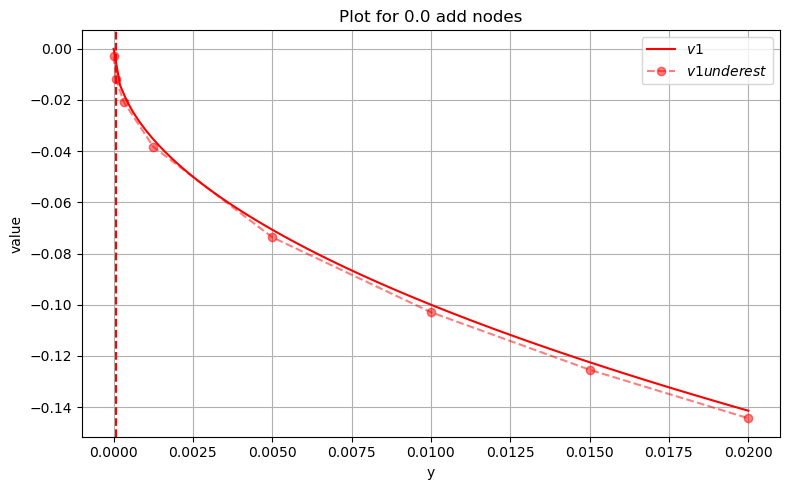

   
   
   
effective add node num  0
y node is  [0.00000000e+00 7.81250000e-05 3.12500000e-04 1.25000000e-03
 2.81516692e-03 5.00000000e-03 1.00000000e-02 1.50000000e-02
 2.00000000e-02]
y node length 9
ms value is  [-0.0022098770167209496, -2.999265325334677e-08]
new_nodes is  0.0028151669229863523
this time choose scenario  0


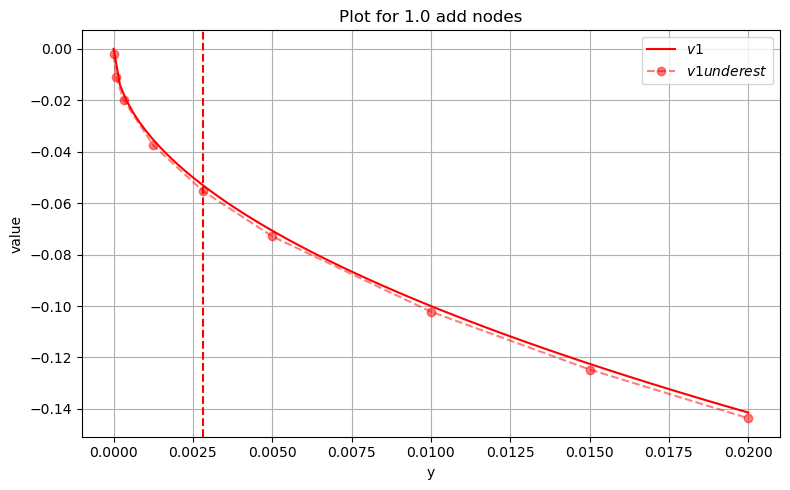

In [16]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.002946340225209102, 0.002209907009374203, 0.001473193420556334, 0.0012563228615291785, 0.001102818839400535, 0.0008863420589638161, 0.0007367102372519128, 0.0006296646400794784, 0.0005678028104564676, 0.0005539319839785389, 0.0004435958536974688, 0.0003701720470681944]


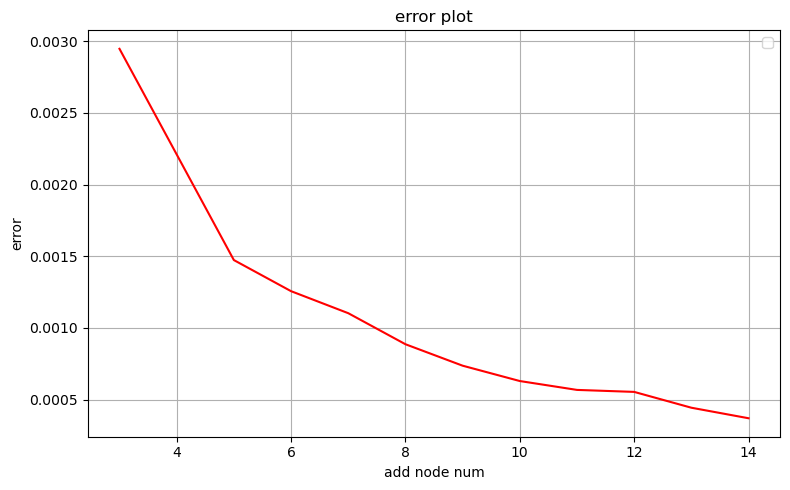

In [22]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [71]:
errors

[0.05261493353885349,
 0.02466310269684402,
 0.010686826841646235,
 0.006028247444075374,
 0.0036989896053867266,
 0.0013698308624792155,
 0.0006840984333196243,
 0.003495651564627167,
 0.0027903822760619867,
 0.002327273459130863,
 0.001996803133321068,
 0.0017929039039972228,
 0.0017485693658303436,
 0.001394714262227481,
 0.001159715011047835]

In [10]:
m = ConcreteModel()
m.y = Var(bounds=(0, 1))
m.x1 = Var(bounds=(0, 1))
m.x11 = Var(bounds=(0, None))
m.x2 = Var()
m.c1 = Constraint(expr=m.x11**2 == m.y**2)
m.c2 = Constraint(expr=m.x11 == (m.x1)**2)
m.c3 = Constraint(expr=m.x2 == -(m.y-1)**2)
m.obj = Objective(expr=-m.x1+m.x2, sense=minimize)

In [11]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [12]:
results = solver.solve(m)
mmm = results.problem.lower_bound

In [18]:
mmm = 0